# Do the model amino acid probabilies correspond with actual increases in temperature?

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import MDAnalysis as mda
import io
import copy
sns.set_style('ticks')
sns.set_context('talk')

In [131]:
aa_three_to_one = {
    'ALA': 'A',
    'ARG': 'R',
    'ASN': 'N',
    'ASP': 'D',
    'CYS': 'C',
    'GLN': 'Q',
    'GLU': 'E',
    'GLY': 'G',
    'HIS': 'H',
    'ILE': 'I',
    'LEU': 'L',
    'LYS': 'K',
    'MET': 'M',
    'PHE': 'F',
    'PRO': 'P',
    'SER': 'S',
    'THR': 'T',
    'TRP': 'W',
    'TYR': 'Y',
    'VAL': 'V'
}

In [2]:
import logging
import numpy as np
import pandas as pd
import os
import re
import torch
import pprint
from yaml import safe_load, dump
from torch.utils.data import DataLoader
from tqdm import tqdm

from datasets import load_from_disk
from evaluate import load
import transformers.integrations
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    T5Tokenizer,
    DataCollatorForSeq2Seq
)


2023-09-14 10:27:43.379599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 10:27:44.969382: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[2023-09-14 10:28:26,823] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### load wild type sequence and mutations

https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/cctc.202101349

In [3]:
full_seqs = {
    'LovD': "MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNARLRERRGKITLRHLLTHTSGLSYVFLHPLLREYMAQGHLQSAEKFGIQSRLAPPAVNDPGAEWIYGANLDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADQTHRNSADGRLRYDDSVYFRADGEECFGGQGVFSGPGSYMKVLHSLLKRDGLLLQPQTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSLTFGGGPNIVWQIDPKAGLCTLAFFQLEPWNDPVCRDLTRTFEHAIYAQYQQG",
    'LovD1': "MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNARLRERRGKITLRHLLTHTSGLSYVFLHPLLREYMAQGHLQSAEKFGIQSRLAPPAVNDPGAEWIYGANLDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADQTHRNSADGRLRYDDSVYFRADGEECFGGQGVFSGPGSYMKVLHSLLKRDGLLLQPQTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIVWQIDPKAGLCTLAFFQLEPWNDPVCRDLTRTFEHAIYAQYQQG",
    'LovD2': "MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYMAQGHLQSAEKFGIQSRFAPPLVNDPGAEWIYGASLDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADQTHRNSSDGRLRYDDSVYFRADGEECFGGQGVFSGPGSYMKVLHSLLKRDGLLLQPQTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIVWQIDPKAGLCTLAFFQLEPWNDPVCRDLTRTFEHAIYAQYQQG",
    'LovD3': "MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYMAQGHLQSAEKFGIQSRFAPPLVNDPGAEWIYGASLDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADQTHRNSSDGRLRYDDSVYFRADGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPQTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIVWQIDPKAGLCTLAFFQLEPWNDPVCRDLTRTFEHAIYAQYQQG",
    'LovD4': "MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYVAQGHLQSAEKFGIQNRFAPPLVNDPGAEWIYGASLDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADQTHRNSSDGRLRYDDSVYFRADGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPQTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIVWQIDPKAGLCTLAFFQLEPWNDPVCRDLTRTFEHAIYAQYQQG",
    'LovD5': "MGSIIDAAVAADPVVLMETAFRKAVESRQIPGAVIMARDASGNLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYVAQGHLQSAEKFGIQNRFAPPLVNDPGAEWIYGASIDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADQTHRNSSDGKLRYDDSVYFRADGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPETVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIVWQIDPKAGLCTLVFFQLEPWNDPVCRDLTRTFEHAIYAQYQQG",
    'LovD6': "MGSIIDAAVAADPVVLMETAFRKAVESRQIPGAVIMARDASGRLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYVAQGHLQGAEKFGIQNRFAPPLVNDPGAEWIYGAGIDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADMTHRNSSDGKLRYDDSVYFRADGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPETVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIIWQIDPKAGLCTLVFFQLEPWNDPVCRDLTRTFEKAIYAQYQQG",
    'LovD7': "MGSIIDAAVAADPVVLMETAFRKAVESRQIPGAVIMARDASGRLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYVAQGHLQGAEKFGIQNRFAPPLVNDPGAEWIYGAGIDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADMTHRNSSDGKLRYDDTVYFRVDGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPGTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIIWQIDPKAGLCTLVFFQLEPWSDPVCRDLTRTFEKAIYAQYQQG",
    'LovD8': "MGSNIDAAVAADPVVLMETAFRKAVESSQIPGAVIMARDASGRLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVDLDETVDRLLPDLSAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYVAQGHLQGAEKFGIQNRFAPPLVNDPGAEWIYGAGIDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADMTHRNSSDGKLRYDDTVYFRHDGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPGTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVLRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIIWQIDPKAGLCTLVFFQLEPWSDPVCRDLTRTFEKAIYAQYQQG",
    'LovD9': "MGSNIDAAVAADPVVLMETAFRKAVESSQIPGAVLMARDASGRLNYTRCFGARTVRRDENNQLPPLQVDTPCRLASATKLLTTIMALQCMERGLVRLDETVDRLLPDLCAMPVLEGFDDAGNPRLRERRGKITLRHLLTHTSGLSYVFLHPLLREYVAQGHLQGAEKFGIQNRFAPPLVNDPGAEWIYGAGIDWAGKLVERATGLDLEQYLQENICAPLGITDMTFKLQQRPDMLARRADMTHRNSSDGKLRYDDTVYFRHDGEECFGGQGVFSSPGSYMKVLHSLLKRDGLLLQPGTVDLMFQPALEPRLEEQMNQHMDASPHINYGGPMPMVMRRSFGLGGIIALEDLDGENWRRKGSMTFGGGPNIIWQIDPKAGLCTLVFFQLEPWSDPVCRDLTRTFEKAIYAQYQQG"
}

In [4]:
temperatures = [38.5, 39.5, 44.0, 44.3, 45.0, 46.0, 52.0, 49.0, 49.3, 50.8]

In [5]:
def get_mutation_positions(wt, seq):
    assert len(wt) == len(seq)
    positions = []
    for i in range(len(wt)):
        if wt[i] != seq[i]:
            positions.append(i)
    return positions

In [6]:
get_mutation_positions(full_seqs['LovD'], full_seqs['LovD9'],)

[3,
 8,
 25,
 27,
 34,
 42,
 95,
 108,
 122,
 156,
 163,
 171,
 173,
 177,
 190,
 191,
 240,
 246,
 249,
 255,
 260,
 274,
 296,
 334,
 360,
 369,
 382,
 390,
 403]

### Model

In [7]:
with open('../params.yaml', 'r') as f:
        params = safe_load(f)

In [8]:
tokenizer = T5Tokenizer.from_pretrained(params['model']['pretrained_model'])
model_config = AutoConfig.from_pretrained('../data/nomelt-model/model')
for model_hyperparam in params['model']['model_hyperparams']:
    setattr(model_config, model_hyperparam, params['model']['model_hyperparams'][model_hyperparam])
setattr(model_config, 'max_length', params['model']['generation_max_length'])
model = AutoModelForSeq2SeqLM.from_pretrained('../data/nomelt-model/model', config=model_config)
model.to('cuda')

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


T5ForConditionalGeneration(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dro

In [9]:
def prepare_string(string):
    out = ' '.join(string)
    out = re.sub(r"[UZOB]", "X", out)
    return out
def tokenize(in_seq, out_seq):
    a, b = prepare_string(in_seq), prepare_string(out_seq)
    inputs = tokenizer(a, text_target=b)
    return inputs
def dict_to_torch(dic):
    return {k: torch.tensor(v).reshape(1,-1).to('cuda') for k, v in dic.items()}

In [10]:
vocab = tokenizer.get_vocab()

In [157]:
def get_log_probs_dif(wt, seq, use_all_positions=True):
    print(len(wt), len(seq))
    if not use_all_positions:
        positions = get_mutation_positions(wt, seq)
        wt_positions = positions
        seq_positions = positions
    else:
        wt_positions = list(range(len(wt)))
        seq_positions = list(range(len(seq)))

    wt_inputs = tokenize(wt, wt)
    wt_inputs = dict_to_torch(wt_inputs)
    wt_logits = model(**wt_inputs).logits[0].detach().cpu()
    del wt_inputs

    wt_probs_all = torch.softmax(wt_logits, axis=1)

    wt_probs = []
    for pos in wt_positions:
        aa_probs = wt_probs_all[pos]
        aa_true = wt[pos]
        aa_true_index = vocab['▁'+aa_true]
        aa_true_prob = aa_probs[aa_true_index]
        wt_probs.append(float(aa_true_prob))

    seq_inputs = tokenize(wt, seq)
    seq_inputs = dict_to_torch(seq_inputs)
    seq_logits = model(**seq_inputs).logits[0].detach().cpu()
    del seq_inputs

    seq_probs_all = torch.softmax(seq_logits, axis=1)

    seq_probs = []
    for pos in seq_positions:
        aa_probs = seq_probs_all[pos]
        aa_true = seq[pos]
        aa_true_index = vocab['▁'+aa_true]
        aa_true_prob = aa_probs[aa_true_index]
        seq_probs.append(float(aa_true_prob))
    torch.cuda.empty_cache()
    return wt_probs, seq_probs

In [12]:
wt_probs, seq_probs = get_log_probs_dif(full_seqs['LovD'], full_seqs['LovD9'])

In [13]:
sum(wt_probs)

2.4390291003801394

In [14]:
sum(seq_probs)

4.382837396929972

### Run on all of them

In [59]:
df = pd.DataFrame(pd.Series(data=full_seqs), columns=['seq'])

In [60]:
def do_one(v_seq):
    wt_probs, seq_probs = get_log_probs_dif(full_seqs['LovD'], v_seq, use_all_positions=True)
    return (wt_probs, seq_probs)

In [61]:
df['probs_data'] = df['seq'].apply(do_one)

In [62]:
df['T'] = temperatures
df

,seq,probs_data,T
LovD,MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",38.5
LovD1,MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",39.5
LovD2,MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",44.0
LovD3,MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",44.3
LovD4,MGSIIDAAAAADPVVLMETAFRKAVKSRQIPGAVIMARDASGNLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",45.0
LovD5,MGSIIDAAVAADPVVLMETAFRKAVESRQIPGAVIMARDASGNLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",46.0
LovD6,MGSIIDAAVAADPVVLMETAFRKAVESRQIPGAVIMARDASGRLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",52.0
LovD7,MGSIIDAAVAADPVVLMETAFRKAVESRQIPGAVIMARDASGRLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",49.0
LovD8,MGSNIDAAVAADPVVLMETAFRKAVESSQIPGAVIMARDASGRLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",49.3
LovD9,MGSNIDAAVAADPVVLMETAFRKAVESSQIPGAVLMARDASGRLNY...,"([0.9999514818191528, 0.10209151357412338, 0.0...",50.8


In [63]:
def difference_metric(wt_probs, seq_probs):
    try:
        return sum(np.log(seq_probs))/len(seq_probs) - sum(np.log(wt_probs))/len(wt_probs)
    except:
        return 0.0
df['metric'] = df['probs_data'].apply(lambda d: difference_metric(*d))

In [64]:
df['metric']

LovD     0.000000
LovD1   -0.002932
LovD2    0.008703
LovD3    0.015080
LovD4    0.016797
LovD5    0.023328
LovD6    0.043929
LovD7    0.030314
LovD8    0.033560
LovD9    0.016768
Name: metric, dtype: float64

<AxesSubplot: xlabel='T', ylabel='metric'>

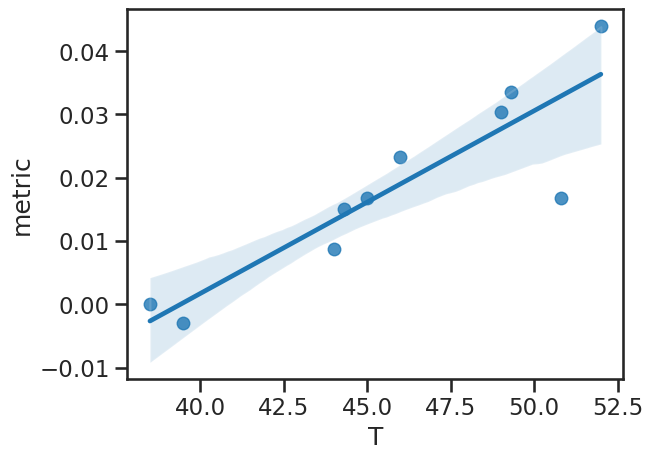

In [65]:
sns.regplot(data=df, x='T', y='metric')

## Another example, variable sequence length

Conformational Stability and Thermodynamics of Folding of Ribonucleases Sa, Sa2 and Sa3

In [66]:
full_seqs2 = {
    'Sa':  "DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPTQSYGYYHEYTVITPGARTRGTRRIITGEATQEDYYTGDHYATFSLIDQTC",
    'Sa2': "ADPALDVCRTKLPSQAQDTLALIAKNGPYPYNRDGVVFENRESRLPKKGNGYYHEFTVVTPGSNERGTRRVVTGGYGEQYESPDHYATFQEIDPRC",
    'Sa3': "ASVKAVGRVCYSALPSQAHDTLDLIDEGGPFPYSQDGVVFQNREGLLPAHSTGYYHEYTVITPGSPTRGARRIITGQQWQEDYYTADHYASFRRVDFAC",
    'Ba':  "AQVINTFDGVADYLQTYHKLPNDYITKSEAQALGWVASKGNLADVAPGKSIGGDIFSNREGKLPGKSGRTWREADINYTSGFRNSDRILYSSDWLIYKTTDHYQTFTKIR",
    'T1':  "ACDYTCGSNCYSSSDVSTAQAAGYQLHEDGETVGSNSYPHKYNNYEGFDFSVSSPYYEWPILSSGDVYSGGSPGADRVVFNENNQLAGVITHTGASGNNFVECT",
    'A': "KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV"
}

In [67]:
temps2 = [48.4, 41.1, 47.2, 53.2, 51.6, 62.8]

In [68]:
df2 = pd.DataFrame(pd.Series(full_seqs2), columns=['seq'])
df2['T'] = temps2
df2

,seq,T
Sa,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4
Sa2,ADPALDVCRTKLPSQAQDTLALIAKNGPYPYNRDGVVFENRESRLP...,41.1
Sa3,ASVKAVGRVCYSALPSQAHDTLDLIDEGGPFPYSQDGVVFQNREGL...,47.2
Ba,AQVINTFDGVADYLQTYHKLPNDYITKSEAQALGWVASKGNLADVA...,53.2
T1,ACDYTCGSNCYSSSDVSTAQAAGYQLHEDGETVGSNSYPHKYNNYE...,51.6
A,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...,62.8


In [74]:
def do_one(v_seq):
    wt_probs, seq_probs = get_log_probs_dif(full_seqs2['Sa'], v_seq, use_all_positions=True)
    return (wt_probs, seq_probs)

In [75]:
df2['probs_data'] = df2['seq'].apply(do_one)

In [76]:
df2['metric'] = df2['probs_data'].apply(lambda d: difference_metric(*d))

<AxesSubplot: xlabel='T', ylabel='metric'>

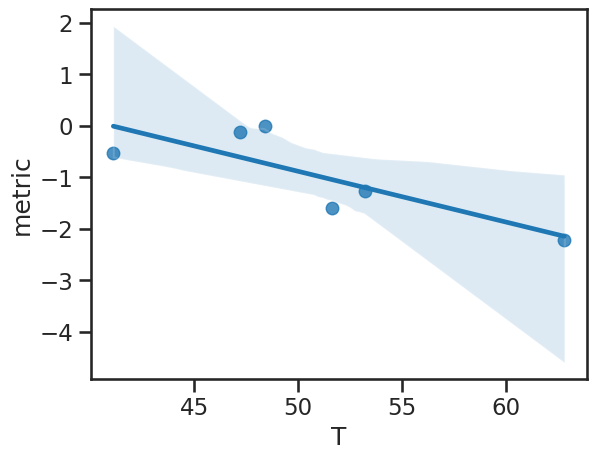

In [77]:
sns.regplot(data=df2, x='T', y='metric')

This one does not work. This is likely due to the way the encoder is fixed by a particular sequence, determined via homology in training data. If we have a different matching patter here, it will not work. A low N number of mutations as in the last case is more robust.

Let's try averging over encoder reference sequences.

In [87]:
def do_one(v_seq):
    wt_probs_list = []
    seq_probs_list = []
    for s in df2.index:
        if full_seqs2[s] == v_seq:
            continue
        wt_probs, seq_probs = get_log_probs_dif(full_seqs2[s], v_seq, use_all_positions=True)
        wt_probs_list.append(wt_probs)
        seq_probs_list.append(seq_probs)
    return (wt_probs_list, seq_probs_list)

In [88]:
df2['probs_data'] = df2['seq'].apply(do_one)

In [96]:
def difference_metric(wt_probs, seq_probs):
    all_vals = []
    for wt, seq in zip(wt_probs, seq_probs):
        try:
            v = sum(np.log(seq))/len(seq) - sum(np.log(wt))/len(wt)
        except:
            v = 0.0
        all_vals.append(v)
    return all_vals
df2['all_metric'] = df2['probs_data'].apply(lambda d: difference_metric(*d))

In [98]:
df2['all_metric'].apply(np.mean)

Sa    -1.382328
Sa2   -1.486910
Sa3   -1.275179
Ba    -1.586756
T1    -1.833478
A     -2.352244
Name: all_metric, dtype: float64

It will not work for this set of data. We need closer homologs.

## Confirm that it works for the other variant sets in the mAFDG paper

In [197]:
LipA = "AEHNPVVMVHGIGGASFNFAGIKSYLVSQGWSRDKLYAVDFWDKTGTNYNNGPVLSRFVQKVLDETGAKKVDIVAHSMGGANTLYYIKNLDGGNKVANVVTLGGANRLTTGKALPGTDPNQKILYTSIYSSADMIVMNYLSRLDGARNVQIHGVGHIGLLYSSQVNSLIKEGLNGGGQNTN"
LipA_mutation_table = pd.read_csv(io.StringIO("""
Name,Mutations,TM (°C)
WT,,56.0
TM,L114P A132D N166Y,61.2
2D9,F17S N89Y L114P A132D I157M N166Y,67.4
4D3,A15S F17S A20E N89Y G111D L114P A132D I157M N166Y,71.2
6B,A15S F17S A20E N89Y G111D L114P A132D M134E M137P I157M S163P N166Y,78.2

"""))

In [198]:
def parse_mutation(mutation_str):
    """
    Parse a mutation string to get the original amino acid, position, and new amino acid.

    Parameters:
        mutation_str (str): The mutation string (e.g., "A132D")

    Returns:
        tuple: original amino acid (str), position (int), new amino acid (str)
    """
    original_aa = mutation_str[0]
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1]) - 1  # Convert to Python 0-based index

    return original_aa, position, new_aa

In [199]:
def check_mutation_table(df, wt):
    df = df.copy()
    df['Mutations'] = df['Mutations'].fillna('')
    df['Mutations'] = df['Mutations'].apply(lambda s: s.split())

    all_mutations = np.unique(np.hstack(df['Mutations'].values))
    print(all_mutations)
    for m in all_mutations:
        a, pos, b = parse_mutation(m)
        assert wt[pos] == a, m
    return df

In [200]:
LipA_mutation_table = check_mutation_table(LipA_mutation_table, LipA)

['A132D' 'A15S' 'A20E' 'F17S' 'G111D' 'I157M' 'L114P' 'M134E' 'M137P'
 'N166Y' 'N89Y' 'S163P']


In [201]:
def convert_seq(mutations):
    seq = list(copy.copy(LipA))
    for m in mutations:
        _, pos, new = parse_mutation(m)
        seq[pos] = new
    return ''.join(seq)

In [202]:
LipA_mutation_table['seq'] = LipA_mutation_table['Mutations'].apply(convert_seq)

In [203]:
def do_one(v_seq):
    wt_probs, seq_probs = get_log_probs_dif(LipA, v_seq, use_all_positions=False)
    return (wt_probs, seq_probs)

In [204]:
LipA_mutation_table['probs_data'] = LipA_mutation_table['seq'].apply(do_one)

181 181
181 181
181 181
181 181
181 181


In [211]:
def difference_metric(wt_probs, seq_probs):
    try:
        return sum(np.log(seq_probs))/len(seq_probs)  - sum(np.log(wt_probs))/len(wt_probs)
    except:
        return 0.0
LipA_mutation_table['metric'] = LipA_mutation_table['probs_data'].apply(lambda d: difference_metric(*d))

In [212]:
LipA_mutation_table

,Name,Mutations,TM (°C),seq,probs_data,metric
0,WT,[],56.0,AEHNPVVMVHGIGGASFNFAGIKSYLVSQGWSRDKLYAVDFWDKTG...,"([], [])",0.000000
1,TM,"[L114P, A132D, N166Y]",61.2,AEHNPVVMVHGIGGASFNFAGIKSYLVSQGWSRDKLYAVDFWDKTG...,"([0.15163595974445343, 0.11841215938329697, 0....",-1.281055
2,2D9,"[F17S, N89Y, L114P, A132D, I157M, N166Y]",67.4,AEHNPVVMVHGIGGASSNFAGIKSYLVSQGWSRDKLYAVDFWDKTG...,"([0.2528879642486572, 0.10695084184408188, 0.1...",-0.897192
3,4D3,"[A15S, F17S, A20E, N89Y, G111D, L114P, A132D, ...",71.2,AEHNPVVMVHGIGGSSSNFEGIKSYLVSQGWSRDKLYAVDFWDKTG...,"([0.021892203018069267, 0.2528879642486572, 0....",-0.371993
4,6B,"[A15S, F17S, A20E, N89Y, G111D, L114P, A132D, ...",78.2,AEHNPVVMVHGIGGSSSNFEGIKSYLVSQGWSRDKLYAVDFWDKTG...,"([0.021892203018069267, 0.2528879642486572, 0....",0.137101


<AxesSubplot: xlabel='TM (°C)', ylabel='metric'>

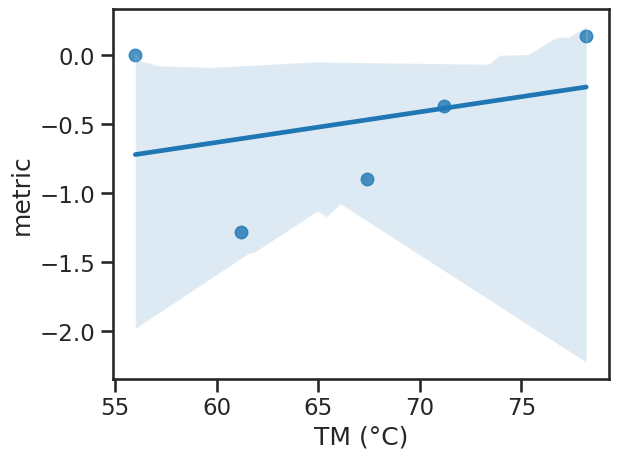

In [213]:
sns.regplot(data=LipA_mutation_table, x='TM (°C)', y='metric')